 # Introduction to Information Retrieval
 
Hasta ahora, hemos estado viendo problemas de Language Processing, básicamente problemas del tipo, que tipo de texto es este (text classification), o que tipo de palabra es esta (sequence labeling), pero que pasa si el problema que queremos resolver es, por ejemplo un sistema recomendador? Es decir, que el output space en lugar de unos labels previamente definidos son direcamente una serie de documentos. Creamos un output space de D documentos? Tiene sentido?

Imaginaros que queremos tener un buscador de libros. 

<div align='center'> 
![](https://i.imgur.com/CLRu4C7.png)
</div>

<div align='center'> 
![](https://i.imgflip.com/1k1hky.jpg =300x)
</div>



Pues empezamos mal. Si hacemos labels de eBooks, primero tendremos que taggear 800.00 ebooks, si queremos ir a libros de toda la vida, 1.8M de labels. Quizás tenemos suerte y hay repetidos, diferentes ediciones, diferentes publishers, etc etc... Lo bajamos a 1M de titulos, por pura generosidad. Vamos a entrenar una red con una capa final de 1M posiciones?

No parece una solución muy interesante, la verdad. Pero aún peor. Cada día, cuando tengamos nuevos libros que vender... que hacemos? Re-entrenamos nuestro modelo? Cada vez parece menos viable. Aunque quizás podríamos.... Empezemos por el principio, y vayamos a lo que seguro funciona

### Que hacemos pues?

Primero una definición, para que entendamos y compartamos concepto de lo que significa Information Retrieval.

> Information retrieval (IR) is finding material (usually documents) of an unstructured nature (usually text) that satisfies an information need
from within large collections (usually stored on computers).

Es decir, encontrar material relevante dada una query, y una colección de documentos. En los últimos tiempos, y con técnicas más o menos avanzadas, el formato de las queries ha ido cambiando, y búsquedas no-textuales han tomado muchísima relevancia. No obstante, durante esta sesión nos centraremos sólo en texto.

Aquí podéis ver un diagrama de una arquitectura genérica

<div align='center'>
![](https://image.slidesharecdn.com/tdminformationretrieval-150803041801-lva1-app6891/95/tdm-information-retrieval-13-638.jpg?cb=1438575616 =400x)
</div>

#### Partes de la arquitectura

* The User: ....
* Query: "comics de batman"
* Query operations: Transforma la query de texto, en alguna representación común a la de los documentos.
* Document collection: ...
* Indexer: Representación común de los documentos.
* Retrieval System + Rankeo: Modelo o sistema, que calcula que documentos son más relevantes, dada la query del usuario.

### Como lo hacemos?

Veremos un par de approaches al sistema de retrieval. Veréis que hay una conexión brutal, sobretodo en los métodos que vimos de preproceso, y n-grams, con lo que reaprovecharemos conocimientos de las primeras sesiones. La sesión se centrara entorno a un algoritmo muy concreto que veremos en breve.

### Recursos

* [Information Retrieval Book](https://nlp.stanford.edu/IR-book/) Recomendadíssimo.

* [Papers](https://ai.google/research/pubs?area=InformationRetrievalandtheWeb), muchos papers

* [Neural IR Recap](https://arxiv.org/pdf/1705.01509.pdf)

## Boolean Retrieval

El primero de los métodos que exploraremos brevemente, son las representaciones booleanas. Basicamente,  representaremos los documentos y las queries con vectores True/False (1/0). Cuál es el tamaño de un vector que represente un documento o una query? Como ya hemos visto anteriormente, el tamaño del vocabulario V.

Cómo representaremos nuestro conjunto de documentos? Una matriz de D x V, es decir, D documentos de tamaño V.

### Breve Repaso y ejemplo

Veremos tambien como representar documentos de tamaño D, de forma más compacta.

In [0]:
import numpy as np

In [0]:
V = 5
D = 3

a = np.random.randint(2, size=(D,V), dtype="bool")
a.shape

(3, 5)

Con numpy tambien podemos hacer uso de puertas lógicas que nos va perfecto.

In [0]:
a[0,:].shape

(5,)

In [0]:
a[:,1].shape

(3,)

In [0]:
feat_vect = np.logical_and(np.logical_and(a[0,:], a[1,:]), np.logical_not(a[2,:]))
feat_vect

array([False, False, False, False, False])

Por ejemplo, si quiero todos los documentos que contengan el termino 0, 1 y NO contengan el 2.

In [0]:
feat_vect = np.array([True, True, False, False, False])

In [0]:
a

array([[ True,  True, False, False, False],
       [False, False, False, False,  True],
       [False, False, False,  True, False]])

In [0]:
np.dot(a, feat_vect)

array([ True, False, False])

In [0]:
a[2,:]

array([False, False, False,  True, False])

### Sparse Representations

In [0]:
from scipy.sparse import csr_matrix

In [0]:
a_sparse = csr_matrix(a)
a_sparse[:].nonzero()

(array([0, 0, 1, 2], dtype=int32), array([0, 1, 4, 3], dtype=int32))

In [0]:
from sys import getsizeof
print(getsizeof(a), getsizeof(a_sparse))

127 56


## Inverted Indexes

In [0]:
documents = ["Julio Cesar era un emperador romano", "La ensalada Cesar lleva tomate lechuga y pollo",
             "El restaurante Casa Cesar ofrece una variedad de platos muy grande", "Las ensaladas son muy sanas",
             "A Cesar le gustan mucho las ensaladas", 
             "Cesar era el emperador más querido. A Cesar le construyeron un museo. Los hombres y mujeres aclamaban a Cesar"]

In [0]:
vocabulary = set([t for doc in documents for t in doc.split(" ")])
w2id = {k:i for i, k in enumerate(vocabulary)}

In [0]:
doc_matrix = np.zeros((len(documents), len(vocabulary)))
doc_matrix.shape

(6, 42)

In [0]:
for i, doc in enumerate(documents):
    for t in doc.split(" "):
        doc_matrix[i,w2id[t]]+=1
doc_matrix

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 1., 0.],
       [1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0.,

In [0]:
inverted_index = {}
for id_doc, doc in enumerate(documents):
    for t in doc.split(" "):
        if t in inverted_index:
            inverted_index[t].append(id_doc)
        else:
            inverted_index[t] = [id_doc]
inverted_index

{'A': [4, 5],
 'Casa': [2],
 'Cesar': [0, 1, 2, 4, 5, 5, 5],
 'El': [2],
 'Julio': [0],
 'La': [1],
 'Las': [3],
 'Los': [5],
 'a': [5],
 'aclamaban': [5],
 'construyeron': [5],
 'de': [2],
 'el': [5],
 'emperador': [0, 5],
 'ensalada': [1],
 'ensaladas': [3, 4],
 'era': [0, 5],
 'grande': [2],
 'gustan': [4],
 'hombres': [5],
 'las': [4],
 'le': [4, 5],
 'lechuga': [1],
 'lleva': [1],
 'mucho': [4],
 'mujeres': [5],
 'museo.': [5],
 'muy': [2, 3],
 'más': [5],
 'ofrece': [2],
 'platos': [2],
 'pollo': [1],
 'querido.': [5],
 'restaurante': [2],
 'romano': [0],
 'sanas': [3],
 'son': [3],
 'tomate': [1],
 'un': [0, 5],
 'una': [2],
 'variedad': [2],
 'y': [1, 5]}

In [0]:
# small improvement and common storage
inverted_index = {}
for id_doc, doc in enumerate(documents):
    for pos, t in enumerate(doc.split(" ")):
        if t in inverted_index:
            inverted_index[t].append((id_doc,pos))
        else:
            inverted_index[t] = [(id_doc,pos)]
inverted_index

{'A': [(4, 0), (5, 6)],
 'Casa': [(2, 2)],
 'Cesar': [(0, 1), (1, 2), (2, 3), (4, 1), (5, 0), (5, 7), (5, 18)],
 'El': [(2, 0)],
 'Julio': [(0, 0)],
 'La': [(1, 0)],
 'Las': [(3, 0)],
 'Los': [(5, 12)],
 'a': [(5, 17)],
 'aclamaban': [(5, 16)],
 'construyeron': [(5, 9)],
 'de': [(2, 7)],
 'el': [(5, 2)],
 'emperador': [(0, 4), (5, 3)],
 'ensalada': [(1, 1)],
 'ensaladas': [(3, 1), (4, 6)],
 'era': [(0, 2), (5, 1)],
 'grande': [(2, 10)],
 'gustan': [(4, 3)],
 'hombres': [(5, 13)],
 'las': [(4, 5)],
 'le': [(4, 2), (5, 8)],
 'lechuga': [(1, 5)],
 'lleva': [(1, 3)],
 'mucho': [(4, 4)],
 'mujeres': [(5, 15)],
 'museo.': [(5, 11)],
 'muy': [(2, 9), (3, 3)],
 'más': [(5, 4)],
 'ofrece': [(2, 4)],
 'platos': [(2, 8)],
 'pollo': [(1, 7)],
 'querido.': [(5, 5)],
 'restaurante': [(2, 1)],
 'romano': [(0, 5)],
 'sanas': [(3, 4)],
 'son': [(3, 2)],
 'tomate': [(1, 4)],
 'un': [(0, 3), (5, 10)],
 'una': [(2, 5)],
 'variedad': [(2, 6)],
 'y': [(1, 6), (5, 14)]}

In [0]:
query = ['ensalada', 'Cesar']

In [0]:
# OR
for q_item in query:
    if q_item in inverted_index:
        for doc_id in inverted_index[q_item]:
            print(documents[doc_id[0]])

La ensalada Cesar lleva tomate lechuga y pollo
Julio Cesar era un emperador romano
La ensalada Cesar lleva tomate lechuga y pollo
El restaurante Casa Cesar ofrece una variedad de platos muy grande
A Cesar le gustan mucho las ensaladas
Cesar era el emperador más querido. A Cesar le construyeron un museo. Los hombres y mujeres aclamaban a Cesar
Cesar era el emperador más querido. A Cesar le construyeron un museo. Los hombres y mujeres aclamaban a Cesar
Cesar era el emperador más querido. A Cesar le construyeron un museo. Los hombres y mujeres aclamaban a Cesar


In [0]:
# AND
possible_docs ={}
for q_item in query:
    if q_item in inverted_index:
        for doc_id in inverted_index[q_item]:
            if doc_id[0] in possible_docs:
                possible_docs[doc_id[0]]+=1
            else:
                possible_docs[doc_id[0]]=1
true_docs = [doc_id for doc_id, count in possible_docs.items() if count == len(query)]
for doc in true_docs:
    print(documents[doc])

La ensalada Cesar lleva tomate lechuga y pollo


## Vector Spaces 

<div align="center">
    ![](http://blog.christianperone.com/wp-content/uploads/2013/09/vector_space.png =400x)
</div>

La diferencia entre boolean search y vector spaces, es que cada posición del vector en lugar de ser un booleano, ahora tendremos pesos en cada posición del vector. Este tipo de algoritmo ha sido el más común en los buscadores de los últimos años, aunque últimamente se pueden ver sobrepasados por deep learning. No obstante, sigue siendo muy común encontrarnos con este tipo de arquitecturas.

<div align='center'>
![](https://static.wixstatic.com/media/1cd646_3e5b7f0d10e34c04ba293144c637e1eb~mv2.jpg/v1/fill/w_762,h_403,al_c,q_80,usm_0.66_1.00_0.01/1cd646_3e5b7f0d10e34c04ba293144c637e1eb~mv2.webp)
</div>

### TF-IDF

Term frequency - Inverse document frequency.

Hasta ahora hemos trabajado con booleans, es decir, esta o no esta el termino en un documento. Pero en documentos, largos que este o no este, no nos da información sobre si aparece mucho un termino o poco. También es verdad que para la relevancia, normalmente asumimos que cuanto mas aparezca este termino, mas importante sera el documento.

Aunque no es siempre así, por ejemplo las conocidas como stop words, hay otros casos que iremos explicando poco a poco y que salen de la misma logica de las stop words.

El weigth dado por el algoritmo tf-idf equivale a cuantas más veces aparezca una palabra en un documento, y cuantas menos veces aparezca en otros documentos, más importante será esa palabra para ese documento.

#### TF
Primero calcularemos el paso más obvio y básico, el term frequency, y luego veremos como mejorarlo.
<div align='center'>
![](https://i.imgur.com/9o3G6Ia.png)*IR book*
</div>

In [0]:
nb_docs = len(documents)
vocab_size = len(vocabulary)

In [0]:
vector_docs = np.zeros(shape=(nb_docs, vocab_size))
vector_docs.shape

(6, 42)

#### Hay varias formas de calcular el term frequency

In [0]:
# Bool
tf_w = np.zeros(shape=(nb_docs, vocab_size))
for i, doc in enumerate(documents):
    for t in doc.split(" "):
        tf_w[i, w2id[t]] = 1

In [0]:
# raw
tf_w = np.zeros(shape=(nb_docs, vocab_size))
for i, doc in enumerate(documents):
    for t in doc.split(" "):
        tf_w[i, w2id[t]] += 1

In [0]:
# Common term frequency
tf_w = np.zeros(shape=(nb_docs, vocab_size))
for i, doc in enumerate(documents):
    for t in doc.split(" "):
        tf_w[i, w2id[t]] += 1
    tf_w[i,:] /=len(doc.split(" "))


In [0]:
# logarithm
def apply_log(a, eps=0.1):
    a = a if a > 0 else eps
    return np.log(1+a)
vlog = np.vectorize(apply_log)

In [0]:
tf_w = np.zeros(shape=(nb_docs, vocab_size))
for i, doc in enumerate(documents):
    for t in doc.split(" "):
        tf_w[i, w2id[t]] += 1
tf_w = vlog(tf_w)
tf_w[0,:]

array([0.09531018, 0.09531018, 0.09531018, 0.09531018, 0.09531018,
       0.09531018, 0.09531018, 0.09531018, 0.09531018, 0.09531018,
       0.09531018, 0.09531018, 0.69314718, 0.09531018, 0.09531018,
       0.69314718, 0.09531018, 0.09531018, 0.09531018, 0.09531018,
       0.09531018, 0.09531018, 0.69314718, 0.09531018, 0.09531018,
       0.09531018, 0.09531018, 0.09531018, 0.69314718, 0.69314718,
       0.09531018, 0.09531018, 0.69314718, 0.09531018, 0.09531018,
       0.09531018, 0.09531018, 0.09531018, 0.09531018, 0.09531018,
       0.09531018, 0.09531018])

In [0]:
from collections import Counter

In [0]:
# augmented
def apply_augmented(a, max_w):
    return 0.5+((0.5*a)/max_w)
vaug = np.vectorize(apply_augmented)

In [0]:
tf_w = np.zeros(shape=(nb_docs, vocab_size))
for i, doc in enumerate(documents):
    tokens = doc.split(" ")
    max_w = Counter(tokens).most_common(1)[0][1]
    for t in tokens:
        tf_w[i, w2id[t]] += 1
    tf_w[i,:] = vaug(tf_w[i,:], max_w)

### IDF

El IDF se computa como el numero de documentos dividido por el numero de veces que aparece el termino t en un la colección de documentos.

In [0]:
from math import log

In [0]:
# calcularemos en cuantos documentos aparece el termino t
df_dict = {w:0 for w in vocabulary}
for doc in documents:
    for w in df_dict.keys():
        if w in doc.split(" "):
            df_dict[w]+=1.0

In [0]:
# basic idf
idf_w = np.zeros(shape=(nb_docs, vocab_size))
for i, doc in enumerate(documents):
    tokens = doc.split(" ")
    for t in tokens:
        idf_w[i, w2id[t]] = log(nb_docs/df_dict[t])

In [0]:
# smooth idf
idf_w = np.zeros(shape=(nb_docs, vocab_size))
for i, doc in enumerate(documents):
    tokens = doc.split(" ")
    for t in tokens:
        idf_w[i, w2id[t]] = log(1+(1+nb_docs/1+df_dict[t]))


## TF-IDF

<div align='center'>
![](https://chrisalbon.com/images/machine_learning_flashcards/TF-IDF_print.png =400x)
</div>

In [0]:
tf_idf_w = tf_w * idf_w
tf_idf_w.shape

(6, 42)

In [0]:
tf_idf_w[5,:]

array([0.        , 1.46481638, 0.        , 1.46481638, 0.        ,
       1.46481638, 0.        , 0.        , 1.46481638, 0.        ,
       1.53505673, 0.        , 2.56494936, 0.        , 1.46481638,
       1.53505673, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.53505673, 1.53505673, 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.53505673,
       1.46481638, 1.53505673, 0.        , 1.46481638, 0.        ,
       1.46481638, 0.        , 1.46481638, 1.46481638, 0.        ,
       0.        , 0.        ])

### Feature Matrix

Visualizar cada documento como un vector de features con pandas

In [0]:
import pandas as pd

In [0]:
pd.DataFrame(tf_idf_w, columns=vocabulary)

,variedad,Los,sanas,hombres,de,más,El,una,el,muy,...,Julio,museo.,ofrece,aclamaban,pollo,querido.,construyeron,lleva,lechuga,mucho
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.197225,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.197225,0.000000,0.000000,2.197225,2.197225,0.000000
2,2.197225,0.000000,0.000000,0.000000,2.197225,0.000000,2.197225,2.197225,0.000000,2.302585,...,0.000000,0.000000,2.197225,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,2.197225,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.302585,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.197225
5,0.000000,1.464816,0.000000,1.464816,0.000000,1.464816,0.000000,0.000000,1.464816,0.000000,...,0.000000,1.464816,0.000000,1.464816,0.000000,1.464816,1.464816,0.000000,0.000000,0.000000


In [0]:
documents

['Julio Cesar era un emperador romano',
 'La ensalada Cesar lleva tomate lechuga y pollo',
 'El restaurante Casa Cesar ofrece una variedad de platos muy grande',
 'Las ensaladas son muy sanas',
 'A Cesar le gustan mucho las ensaladas',
 'Cesar era el emperador más querido. A Cesar le construyeron un museo. Los hombres y mujeres aclamaban a Cesar']

## Visto con Sci-kit (sk learn)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
docs = np.array(documents)
tfidf = TfidfVectorizer()
feature_matrix = tfidf.fit_transform(docs)


In [0]:
pd.DataFrame(feature_matrix.toarray(), columns=tfidf.get_feature_names())

,aclamaban,casa,cesar,construyeron,de,el,emperador,ensalada,ensaladas,era,...,pollo,querido,restaurante,romano,sanas,son,tomate,un,una,variedad
0,0.000000,0.000000,0.247650,0.000000,0.000000,0.000000,0.396380,0.000000,0.000000,0.396380,...,0.000000,0.000000,0.000000,0.483382,0.000000,0.000000,0.000000,0.396380,0.000000,0.000000
1,0.000000,0.000000,0.204726,0.000000,0.000000,0.000000,0.000000,0.399601,0.000000,0.000000,...,0.399601,0.000000,0.000000,0.000000,0.000000,0.000000,0.399601,0.000000,0.000000,0.000000
2,0.000000,0.322626,0.165290,0.000000,0.322626,0.264558,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.322626,0.000000,0.000000,0.000000,0.000000,0.000000,0.322626,0.322626
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.409125,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.498924,0.498924,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.247650,0.000000,0.000000,0.000000,0.000000,0.000000,0.396380,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.269931,0.000000,0.414879,0.269931,0.000000,0.221347,0.221347,0.000000,0.000000,0.221347,...,0.000000,0.269931,0.000000,0.000000,0.000000,0.000000,0.000000,0.221347,0.000000,0.000000


## Plotting documents

In [0]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tfidf_low_dim = TSNE(n_components=2).fit_transform(tf_idf_w)

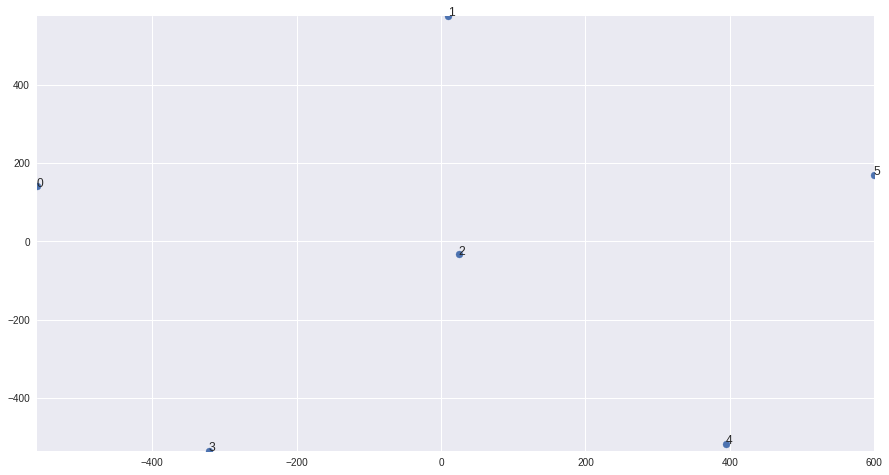

In [0]:
maxx = max(tfidf_low_dim[:, 0])+0.0001
minx = min(tfidf_low_dim[:, 0])-0.0001
maxy = max(tfidf_low_dim[:, 1])+0.0001
miny = min(tfidf_low_dim[:, 1])-0.0001

fig, ax = plt.subplots(figsize=(15, 8))

plt.scatter(tfidf_low_dim[:, 0], tfidf_low_dim[:, 1], cmap=plt.cm.Spectral)
plt.axis([minx, maxx, miny, maxy])
for i, txt in enumerate(np.arange(nb_docs).tolist()):
    ax.annotate(txt, (tfidf_low_dim[:, 0][i],tfidf_low_dim[:, 1][i]))
plt.show()

## Querying the model

<div align="center">
    ![](http://blog.christianperone.com/wp-content/uploads/2013/09/cosinesimilarityfq1.png)
</div>


In [0]:
query = 'ensalada Cesar sanas'

In [0]:
q_w = np.zeros(shape=(1, vocab_size))

for t in query.split(" "):
    if t in w2id:
        q_w[0, w2id[t]] += 1
q_tf = q_w
q_tf.shape

(1, 42)

In [0]:
q_idf = np.zeros(shape=(1, vocab_size))

tokens = query.split(" ")
for t in tokens:
    if t in w2id:
        q_idf[0, w2id[t]] = log((nb_docs/df_dict[t]))
q_idf

array([[0.        , 0.        , 1.79175947, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.18232156, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.79175947, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]])

In [0]:
query_rep = q_tf * q_idf
query_rep

array([[0.        , 0.        , 1.79175947, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.18232156, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.79175947, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]])

### Cosine similarity

Visualización de Cosine Similarity

<div align="center">
    ![](https://lh4.googleusercontent.com/SodVc3Xo77b8LhEjqXymSaA-bI-kQdPeY8uG-J0wSSp5q-pxVAf_rPMUX9Y =400x)
</div>


In [0]:
def cos_similarity(x, y):
    numerator = np.sum(x*y, axis=-1)
    a = np.sqrt(np.sum(x**2, axis=-1))
    b = np.sqrt(np.sum(y**2, axis=-1))
    denominator = a*b
    return numerator/denominator

In [0]:
for i in range(nb_docs):
    print(documents[i], cos_similarity(query_rep, tf_idf_w[i,:]))

Julio Cesar era un emperador romano [0.03246954]
La ensalada Cesar lleva tomate lechuga y pollo [0.27126979]
El restaurante Casa Cesar ofrece una variedad de platos muy grande [0.02474665]
Las ensaladas son muy sanas [0.30939422]
A Cesar le gustan mucho las ensaladas [0.03027524]
Cesar era el emperador más querido. A Cesar le construyeron un museo. Los hombres y mujeres aclamaban a Cesar [0.02834505]


In [0]:
from sklearn.metrics.pairwise import cosine_similarity

In [0]:
cosine_similarity(query_rep, tf_idf_w)

array([[0.03246954, 0.27126979, 0.02474665, 0.30939422, 0.03027524,
        0.02834505]])

In [0]:
tnse_w = np.vstack([tf_idf_w, query_rep])
tnse_w.shape

(7, 42)

In [0]:
tfidf_low_dim = TSNE(n_components=2).fit_transform(tnse_w)

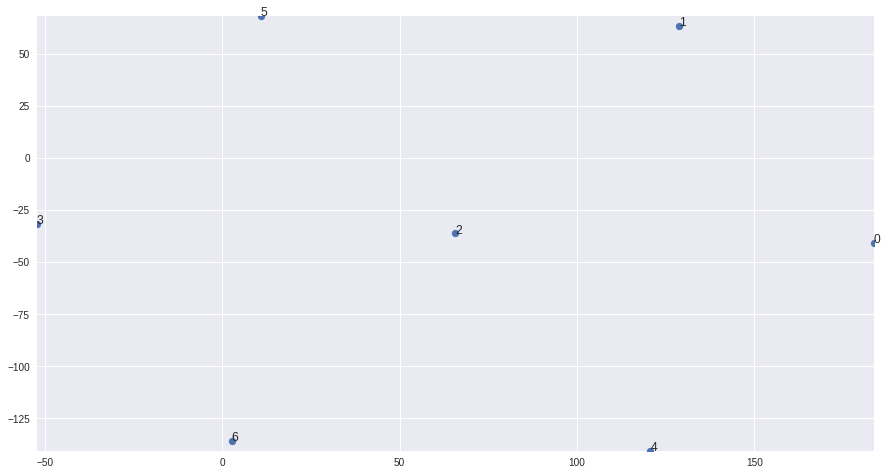

In [0]:
maxx = max(tfidf_low_dim[:, 0])+0.0001
minx = min(tfidf_low_dim[:, 0])-0.0001
maxy = max(tfidf_low_dim[:, 1])+0.0001
miny = min(tfidf_low_dim[:, 1])-0.0001

fig, ax = plt.subplots(figsize=(15, 8))

plt.scatter(tfidf_low_dim[:, 0], tfidf_low_dim[:, 1], cmap=plt.cm.Spectral)
plt.axis([minx, maxx, miny, maxy])
for i, txt in enumerate(np.arange(nb_docs+1).tolist()):
    ax.annotate(txt, (tfidf_low_dim[:, 0][i],tfidf_low_dim[:, 1][i]))
plt.show()

## Evaluación de un modelo

### Precision vs Recall

Seguro que ya lo habéis visto, pero es obligatorio hablar de métricas de evaluación de nuestros sistemas de retrieval. Básicamente, estos métdos de evaluación se usan con test sets en los que tenemos claros los que tenemos etiquetados la relevancia de los documentos respecto a una query, o una série de queries. Cómo os podéis imaginar, no usaremos Accuracy, sino que usaremos Precision vs Recall. Haremos una implementación dummy para que veáis como funcionan.

<div align="center">
![](https://www.researchgate.net/profile/Ioannis_Brilakis/publication/269691283/figure/fig2/AS:295035909230593@1447353450247/Definitions-of-recall-and-precision-in-Information-Retrieval-IR.png =300x)
</div>

#### Precision
<div align="center">
![](https://chrisalbon.com/images/machine_learning_flashcards/Precision_print.png =600x)
</div>



In [0]:
from random import shuffle


database = ['a']*10 + ['b']*5 + ['c']*15 + ['d']*8

In [0]:
def precision(results, correct):
    tp = sum([1.0 for r in results if r==correct])
    tp_fp = len(results)
    print('True Positive: {}'.format(tp))
    print('TruePositive and False Positive: {}'.format(tp_fp))
    
    return tp/tp_fp

In [0]:
shuffle(database)
results = database[0:5]
precision(results, 'a')

True Positive: 0
TruePositive and False Positive: 5


0.0

#### Recall
<div align="center">
![](https://chrisalbon.com/images/machine_learning_flashcards/Recall_print.png =600x)
</div>



In [0]:
def recall(results, collection, correct):
    tp = sum([1.0 for r in results if r==correct])
    
    tp_fn = sum([1.0 for c in collection if c==correct])
    
    print('True Positive: {}'.format(tp))
    print('True Positive and False Negatives: {}'.format(tp_fn))
    
    return tp/tp_fn

In [0]:
shuffle(database)
results = database[0:5]
recall(results, database, 'a')

True Positive: 0
True Positive and False Negatives: 10.0


0.0

### Precision vs Recall Curve

<div align="center">
    ![](https://habrastorage.org/files/26b/c1e/a38/26bc1ea381424262b9d966c63f418661.png)
</div>

### F1 Score

<div align="center">
![](https://chrisalbon.com/images/machine_learning_flashcards/F1_Score_print.png =600x)
</div>


In [0]:
def f1_score(results, collection, correct):
    p = precision(results, correct)
    r = recall(results, collection, correct)
    numerator = p*r
    denominator = p+r
    return 2*numerator/denominator

In [0]:
shuffle(database)
results = database[0:5]
f1_score(results, database, 'a')

True Positive: 1.0
TruePositive and False Positive: 5
True Positive: 1.0
True Positive and False Negatives: 10.0


0.13333333333333333